<a href="https://colab.research.google.com/github/aburak256/Currency-with-Twitter/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements (1).txt
User uploaded file "requirements.txt" with length 357 bytes


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 7.5MB 7.3MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 39.4MB/s 
     |████████████████████████████████| 10.5MB 42.7MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 235kB 43.3MB/s 
     |████████████████████████████████| 17.3MB 142kB/s 
     |████████████████████████████████| 28.4MB 101kB/s 
     |████████████████████████████████| 327kB 35.9MB/s 
     |████████████████████████████████| 86.4MB 59kB/s 
     |████████████████████████████████| 12.4MB 28.4MB/s 
     |████████████████████████████████| 8.7MB 18.3MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 39.5MB/s 
     |████████████████████████████████| 276kB 49.1MB/s 
     |████████████████████████████████| 133kB 45.8MB/s 
     |████████████████████████████████| 133kB 48.8MB/s 


In [1]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

##from utils.metrics import evaluate
##from utils.plots import bar_metrics

from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

INFO:root:Using CPU


2.0.3


In [4]:
url = 'https://raw.githubusercontent.com/aburak256/Currency-with-Twitter/main/Sum_Last.csv?token=AIJJRBFQVN4AHSWNBCTIPP27UAEGY'



In [5]:
exchange_rate = pd.read_csv(url,parse_dates=['Date'])
exchange_rate.set_index('Date',inplace=True)
exchange_rate.head() #

,Rate,Previous
Date,,
2014-01-01 18:00:00,2.14686,2.14793
2014-01-01 19:01:00,2.14680,2.14686
2014-01-01 20:00:00,2.14728,2.14680
2014-01-01 21:00:00,2.14731,2.14728
2014-01-01 22:01:00,2.14697,2.14731


In [6]:
exchange_rate.describe()

,Rate,Previous
count,37198.000000,37198.000000
mean,3.687798,3.687696
std,1.283924,1.283895
min,2.063250,2.063250
25%,2.707725,2.707680
50%,3.469870,3.469440
75%,4.734820,4.734745
max,7.096780,7.096780


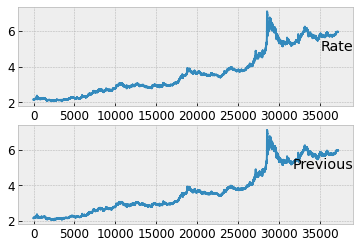

In [7]:
values = exchange_rate.values
groups = [0, 1]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(exchange_rate.columns[group], y=0.5, loc='right')
    i += 1
    

plt.show()

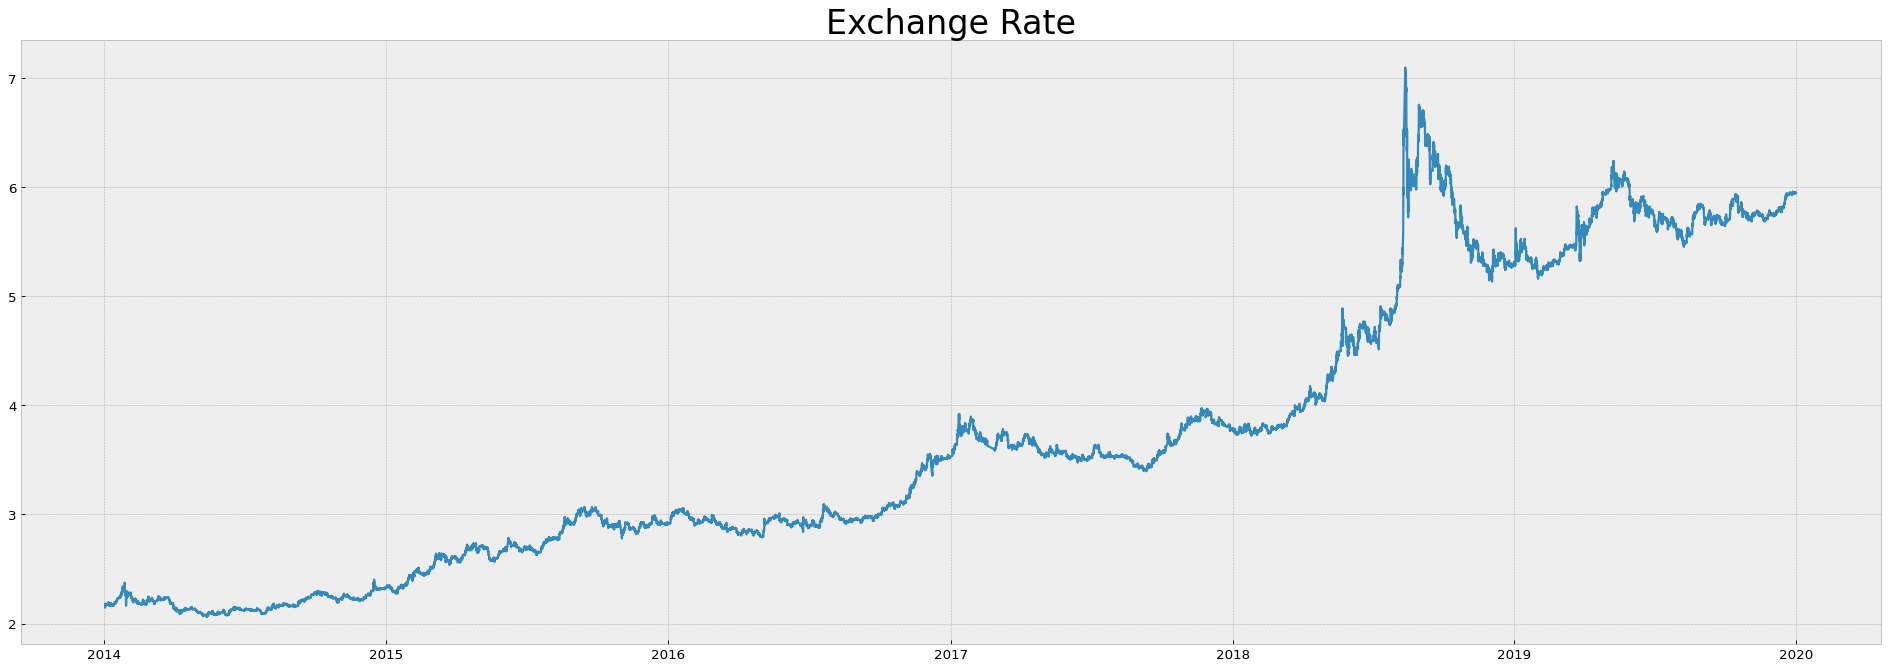

In [8]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Exchange Rate',fontsize=30)

plt.plot(exchange_rate.Rate)
plt.savefig("pollution.png")

<Figure size 4000x1600 with 0 Axes>

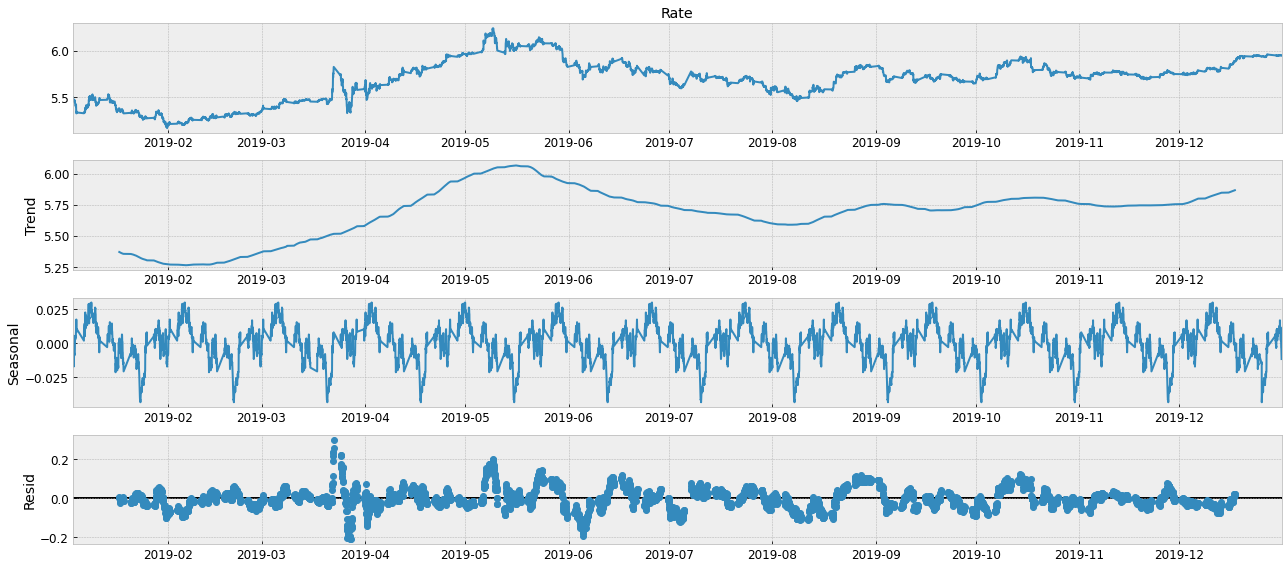

In [49]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = exchange_rate.Rate[-6200:]
result = seasonal_decompose(series, model='additive',period=480 )#additive because seasonality’s amplitude is independent of the level , period = 24* 20 (20 trading days per month)
result.plot()
pass

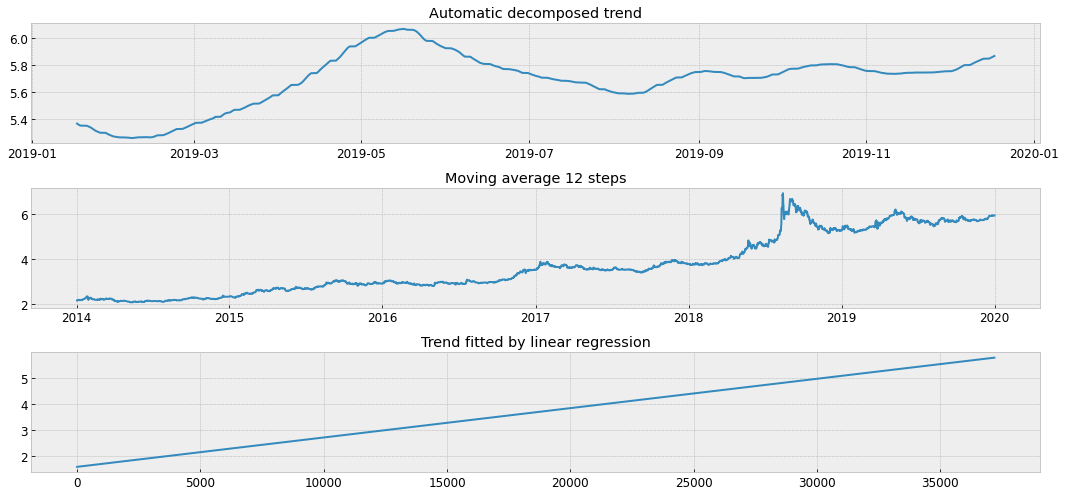

In [47]:

fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = exchange_rate.Rate.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(exchange_rate.Rate))]
X = np.reshape(X, (len(X), 1))
y = exchange_rate.Rate.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

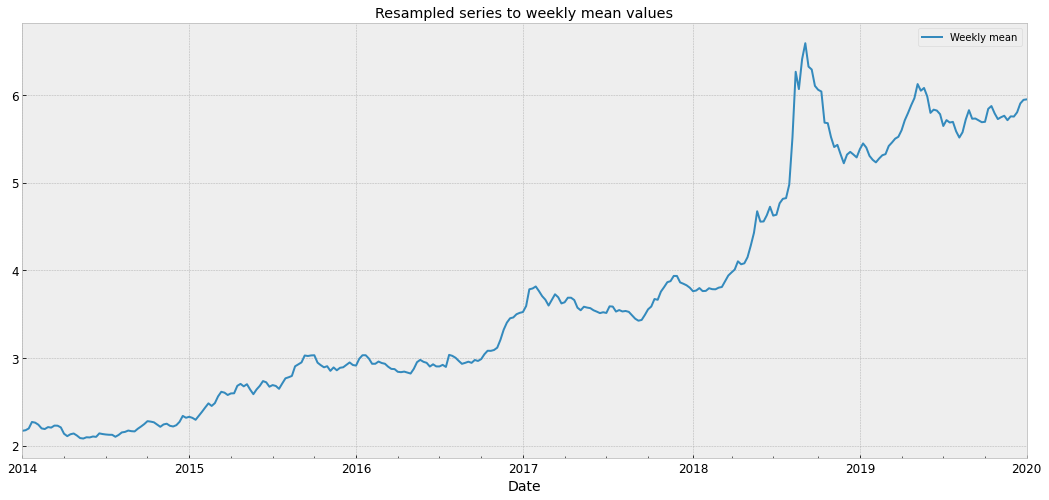

In [57]:
#Looking for weekly seasonality
resample = exchange_rate.resample('W')
weekly_mean = resample.mean()
weekly_mean.Rate.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

Text(0.5, 1.0, 'Mean over time')

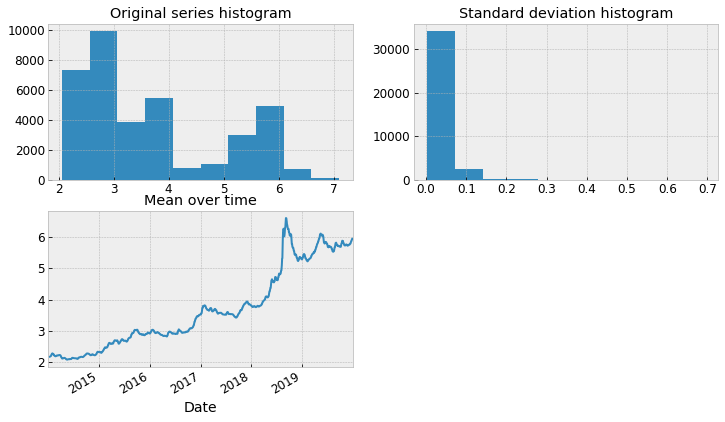

In [74]:
series = exchange_rate.Rate.values
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,0))

exchange_rate.Rate.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

mm = exchange_rate.Rate.rolling(168).std()#168 hours at 1 week
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = exchange_rate.Rate.rolling(168).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

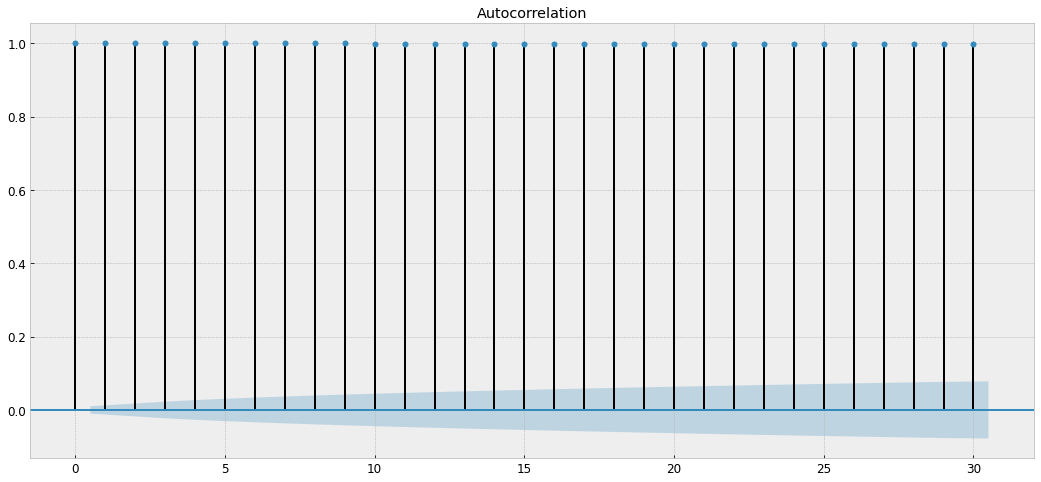

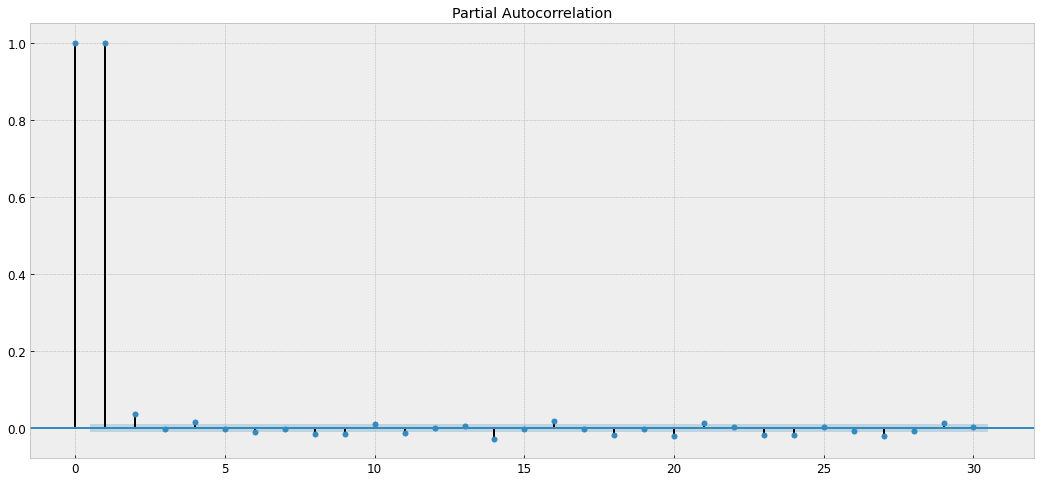

In [70]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time. But if we look at our autocorrelation graph it wont decrease over time.
These graphs shows us that our data is not stationary 

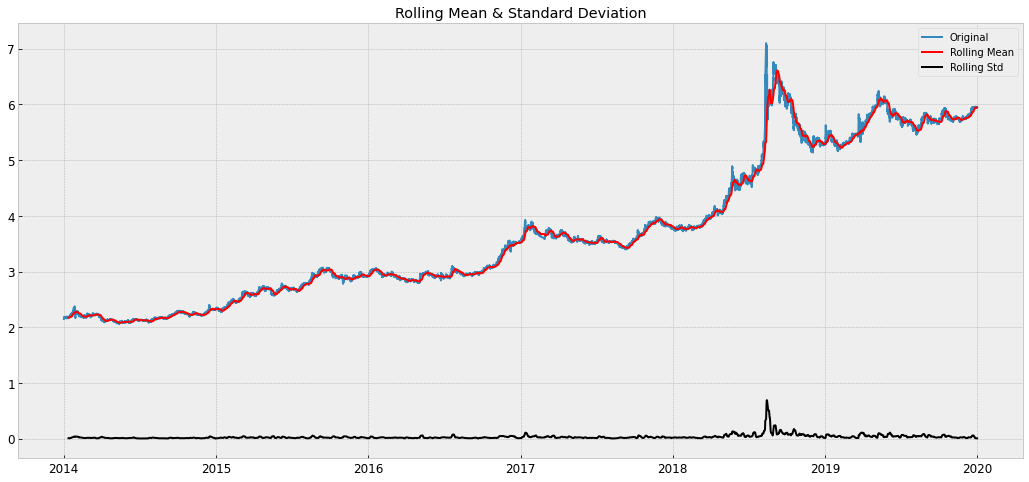

In [73]:
rolmean = exchange_rate.Rate.rolling(window=168).mean()#168 hours at 1 week
rolstd = exchange_rate.Rate.rolling(window=168).std()

#Plot rolling statistics:
orig = plt.plot(exchange_rate.Rate,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Also we can see that our data is not stationary using standart deviation. Mean and standard deviation should be constant over time in order to have a stationary time series.

In [76]:
X = exchange_rate.Rate.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.240683
p-value: 0.933495
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. if p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary